# Hive-DITTO Integration Testing Notebook

This notebook allows you to test the complete Hive data extraction, DITTO entity matching, and result storage workflow before deploying to Kubeflow.

## Workflow Overview:
1. **Setup & Configuration** - Configure connections and parameters
2. **Data Extraction** - Extract data from Hive table to JSONL
3. **Data Preprocessing** - Convert to DITTO format
4. **Entity Matching** - Run DITTO matching
5. **Result Analysis** - Analyze matching results
6. **Save to Hive** - Store results back to Hive

## 1. Setup & Installation

In [5]:
# Install required packages
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import subprocess
import logging
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ Setup completed!")

✓ Setup completed!


## 2. Configuration

In [9]:
# Hive Configuration
HIVE_CONFIG = {
    'host': '172.17.235.21',  # Change to your Hive host
    'port': 10000,
    'database': 'preprocessed_analytics',
    'username': 'lhimer',  # Change to your username
}

# Input/Output Configuration
DATA_CONFIG = {
    'input_table': 'preprocessed_analytics.model_reference',              # Your Hive input table
    'output_table': 'results.ditto_matches',  # Hive output table
    'temp_dir': './temp_notebook',            # Temporary directory
    'input_jsonl': './temp_notebook/input_data.jsonl',
    'output_jsonl': './temp_notebook/output_results.jsonl',
    'sample_size': 1000                       # Number of records to test with
}

# DITTO Configuration
DITTO_CONFIG = {
    'task': 'person_records',
    'lm': 'bert',
    'max_len': 64,
    'checkpoint_path': 'checkpoints/',
    'use_gpu': True,
    'fp16': True
}

# Create temp directory
os.makedirs(DATA_CONFIG['temp_dir'], exist_ok=True)

print("📋 Configuration loaded:")
print(f"  Hive: {HIVE_CONFIG['host']}:{HIVE_CONFIG['port']}")
print(f"  Input table: {DATA_CONFIG['input_table']}")
print(f"  Output table: {DATA_CONFIG['output_table']}")
print(f"  DITTO model: {DITTO_CONFIG['lm']} ({DITTO_CONFIG['task']})")

📋 Configuration loaded:
  Hive: 172.17.235.21:10000
  Input table: preprocessed_analytics.model_reference
  Output table: results.ditto_matches
  DITTO model: bert (person_records)


## 3. Utility Functions

In [22]:
class HiveConnector:
    """Handle Hive database connections and operations."""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.connection = None
    
    def connect(self):
        """Establish connection to Hive."""
        try:
            from pyhive import hive
            self.connection = hive.Connection(
                host=self.config['host'],
                port=self.config['port'],
                database=self.config['database'],
                username=self.config.get('username'),
            )
            logger.info(f"Connected to Hive: {self.config['host']}:{self.config['port']}")
            return True
        except Exception as e:
            logger.error(f"Failed to connect to Hive: {e}")
            return False
    
    def execute_query(self, query: str) -> pd.DataFrame:
        """Execute SQL query and return results as DataFrame."""
        if not self.connection:
            raise RuntimeError("Not connected to Hive")
        
        try:
            df = pd.read_sql(query, self.connection)
            logger.info(f"Query executed successfully, returned {len(df)} rows")
            return df
        except Exception as e:
            logger.error(f"Query failed: {e}")
            raise
    
    def close(self):
        """Close Hive connection."""
        if self.connection:
            self.connection.close()
            logger.info("Hive connection closed")

def convert_to_ditto_format(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """Convert DataFrame to DITTO JSONL format."""
    records = []
    
    for idx, row in df.iterrows():
        # Convert row to COL/VAL format
        col_val_parts = []
        
        for col in df.columns:
            if str(col.split('.', 1)[1]) == "source_table":
                continue
            if pd.notna(row[col]) and str(row[col]).strip():
                value = str(row[col]).strip()
                col_val_parts.append(f"COL {col.split('.', 1)[1]} VAL {value}")
        
        record_text = " ".join(col_val_parts)
        
        # Create JSONL record (modify this logic based on your needs)
        record = {
            "left": record_text,
            "right": record_text,  # For self-matching, change as needed
            "id": idx
        }
        records.append(record)
    
    return records

def analyze_ditto_results(jsonl_path: str) -> Dict[str, Any]:
    """Analyze DITTO matching results."""
    results = []
    
    with open(jsonl_path, 'r') as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    
    if not results:
        return {"error": "No results found"}
    
    # Calculate statistics
    total_pairs = len(results)
    matches = sum(1 for r in results if r.get('match', False))
    match_scores = [r.get('match_confidence', 0.0) for r in results]
    
    return {
        'total_pairs': total_pairs,
        'matches': matches,
        'non_matches': total_pairs - matches,
        'match_rate': matches / total_pairs if total_pairs > 0 else 0,
        'avg_score': np.mean(match_scores) if match_scores else 0,
        'score_distribution': match_scores
    }

print("✓ Utility functions defined!")

✓ Utility functions defined!


## 4. Test Hive Connection

In [23]:
# Test Hive connection
hive_conn = HiveConnector(HIVE_CONFIG)

if hive_conn.connect():
    print("✅ Hive connection successful!")
    
    # Test with a simple query
    try:
        test_df = hive_conn.execute_query("SHOW TABLES")
        print("\n📋 Available tables (sample):")
        display(test_df)
    except Exception as e:
        print(f"⚠️  Could not list tables: {e}")
        print("This might be normal depending on your Hive permissions")
    
else:
    print("❌ Hive connection failed!")
    print("Please check your configuration and ensure Hive is accessible")

2025-07-22 16:51:34,336 - INFO - USE `preprocessed_analytics`
2025-07-22 16:51:34,554 - INFO - Connected to Hive: 172.17.235.21:10000
2025-07-22 16:51:34,556 - INFO - SHOW TABLES
2025-07-22 16:51:34,686 - INFO - Query executed successfully, returned 9 rows


✅ Hive connection successful!

📋 Available tables (sample):


,tab_name
0,model_reference
1,my_splink_final
2,results_dm_dts_beneficiaires_simpl_psig_hadoop
3,results_dm_dts_beneficiaires_simpl_splink_hadoop
4,results_dm_dts_personnel_permanent
5,results_dm_etat_repartition_capital_social_ln_ls
6,results_dm_multiple_sources
7,results_dm_multiple_sources_nid
8,results_dm_releve_de_deductions


## 5. Data Extraction from Hive

In [24]:
# Extract data from Hive table
print(f"🔄 Extracting data from: {DATA_CONFIG['input_table']}")

try:
    # Extract sample data
    query = f"""
    SELECT * FROM {DATA_CONFIG['input_table']} 
    LIMIT {DATA_CONFIG['sample_size']}
    """
    
    df = hive_conn.execute_query(query)
    
    print(f"✅ Extracted {len(df)} records")
    print(f"📊 Columns: {list(df.columns)}")
    
    # Display sample data
    print("\n📋 Sample data:")
    display(df.head())
    
    # Show data info
    print("\n📈 Data info:")
    print(df.info())
    
except Exception as e:
    print(f"❌ Data extraction failed: {e}")
    print("\n💡 Creating sample data for testing...")
    
    # Create sample data if Hive extraction fails
    df = pd.DataFrame({
        'id': range(1, 11),
        'firstname': ['Ahmed', 'Mohamed', 'Fatima', 'Omar', 'Aisha', 'Khalid', 'Layla', 'Hassan', 'Zeinab', 'Ali'],
        'lastname': ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis', 'Rodriguez', 'Martinez'],
        'email': [f'user{i}@example.com' for i in range(1, 11)],
        'phone': [f'555-000{i:04d}' for i in range(1, 11)]
    })
    print(f"✅ Created sample dataset with {len(df)} records")
    display(df)

2025-07-22 16:51:35,340 - INFO - 
    SELECT * FROM preprocessed_analytics.model_reference 
    LIMIT 1000
    


🔄 Extracting data from: preprocessed_analytics.model_reference


2025-07-22 16:51:36,053 - INFO - Query executed successfully, returned 1000 rows


✅ Extracted 1000 records
📊 Columns: ['model_reference.primary_key', 'model_reference.source_table', 'model_reference.ifu', 'model_reference.nom', 'model_reference.prenoms', 'model_reference.raison_sociale', 'model_reference.nom_prenom_rs', 'model_reference.acronym_nom_prenom_rs', 'model_reference.adresse', 'model_reference.date_naissance', 'model_reference.ice', 'model_reference.num_cin', 'model_reference.num_ce', 'model_reference.numero_adhesion_cnss', 'model_reference.num_cnss', 'model_reference.num_ppr', 'model_reference.centre_registre_commerce', 'model_reference.code_centre_registre_commerce', 'model_reference.num_registre_commerce', 'model_reference.num_article_patente', 'model_reference.email_adherent', 'model_reference.num_tel_adherent', 'model_reference.num_passeport']

📋 Sample data:


,model_reference.primary_key,model_reference.source_table,model_reference.ifu,model_reference.nom,model_reference.prenoms,model_reference.raison_sociale,model_reference.nom_prenom_rs,model_reference.acronym_nom_prenom_rs,model_reference.adresse,model_reference.date_naissance,...,model_reference.numero_adhesion_cnss,model_reference.num_cnss,model_reference.num_ppr,model_reference.centre_registre_commerce,model_reference.code_centre_registre_commerce,model_reference.num_registre_commerce,model_reference.num_article_patente,model_reference.email_adherent,model_reference.num_tel_adherent,model_reference.num_passeport
0,678604863659,preprocessed_cleaned_rapprochement.contribuabl...,2860014,None,None,JAMAL ASSAHRAA,JAMAL ASSAHRAA,JA,35 RUE MOULAY ISMAIL DERB BALADIA,None,...,None,6463418,None,CASABLANCA,81,120217,33428294,SOC.JMLSAHRA@GMAIL.COM,0522447801,None
1,292057803428,preprocessed_cleaned_rapprochement.contribuabl...,53960903,None,None,BUILDING BENMILOUD,BUILDING BENMILOUD,BB,46 BD ZERKTOUNI ETG 2 APT 6,None,...,None,None,None,None,None,None,34208658,None,None,None
2,996432433454,preprocessed_cleaned_rapprochement.contribuabl...,52496734,None,None,IS CONFORT,IS CONFORT,IC,MAGASIN SITUE A N1161 MARJANE 5 SBZ,None,...,None,None,None,MEKNES,47,56331,17804199,None,None,None
3,249108155489,preprocessed_cleaned_rapprochement.contribuabl...,50328494,None,None,JAWHARA PRIFA,JAWHARA PRIFA,JP,DOUAR SIDI MOUSSA N 18 COMMUNE TASSELTANTE,None,...,None,None,None,None,None,None,47952044,None,None,None
4,687194804244,preprocessed_cleaned_rapprochement.contribuabl...,33609984,None,None,ALTO ASSURANCES,ALTO ASSURANCES,AA,RESIDENCE IBRAHIM AL KHALIL TRANCHE 1 IMMEUBLE...,None,...,None,1324866,None,TANGER,61,94457,50202653,None,None,None



📈 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   model_reference.primary_key                    1000 non-null   int64 
 1   model_reference.source_table                   1000 non-null   object
 2   model_reference.ifu                            1000 non-null   object
 3   model_reference.nom                            484 non-null    object
 4   model_reference.prenoms                        484 non-null    object
 5   model_reference.raison_sociale                 516 non-null    object
 6   model_reference.nom_prenom_rs                  992 non-null    object
 7   model_reference.acronym_nom_prenom_rs          992 non-null    object
 8   model_reference.adresse                        1000 non-null   object
 9   model_reference.date_naissance                 151

## 6. Convert to DITTO Format

In [28]:
# Convert to DITTO format
print("🔄 Converting data to DITTO format...")

ditto_records = convert_to_ditto_format(df)

print(f"✅ Converted {len(ditto_records)} records to DITTO format")

# Save to JSONL file in the format expected by matcher.py
# Each line should be a JSON array with [left_record, right_record]
with open(DATA_CONFIG['input_jsonl'], 'w', encoding='utf-8') as f:
    for record in ditto_records:
        # Convert from our format to matcher.py expected format
        matcher_record = [record['left'], record['right']]
        f.write(json.dumps(matcher_record, ensure_ascii=False) + '\n')

print(f"💾 Saved to: {DATA_CONFIG['input_jsonl']}")

# Show sample records
print("\n📋 Sample DITTO records:")
for i, record in enumerate(ditto_records[:3]):
    print(f"\nRecord {i+1}:")
    print(f"  Left:  {record['left'][:100]}...")
    print(f"  Right: {record['right'][:100]}...")
    print(f"  ID:    {record['id']}")

# Show the actual JSONL format that will be used by matcher
print("\n📋 Sample JSONL format for matcher:")
with open(DATA_CONFIG['input_jsonl'], 'r') as f:
    for i, line in enumerate(f):
        if i >= 3:  # Show first 3 lines
            break
        sample_data = json.loads(line)
        print(f"\nLine {i+1}: {len(sample_data)} elements")
        print(f"  [0]: {sample_data[0][:80]}...")
        print(f"  [1]: {sample_data[1][:80]}...")

🔄 Converting data to DITTO format...
✅ Converted 1000 records to DITTO format
💾 Saved to: ./temp_notebook/input_data.jsonl

📋 Sample DITTO records:

Record 1:
  Left:  COL primary_key VAL 678604863659 COL ifu VAL 2860014 COL raison_sociale VAL JAMAL ASSAHRAA COL nom_p...
  Right: COL primary_key VAL 678604863659 COL ifu VAL 2860014 COL raison_sociale VAL JAMAL ASSAHRAA COL nom_p...
  ID:    0

Record 2:
  Left:  COL primary_key VAL 292057803428 COL ifu VAL 53960903 COL raison_sociale VAL BUILDING BENMILOUD COL ...
  Right: COL primary_key VAL 292057803428 COL ifu VAL 53960903 COL raison_sociale VAL BUILDING BENMILOUD COL ...
  ID:    1

Record 3:
  Left:  COL primary_key VAL 996432433454 COL ifu VAL 52496734 COL raison_sociale VAL IS CONFORT COL nom_pren...
  Right: COL primary_key VAL 996432433454 COL ifu VAL 52496734 COL raison_sociale VAL IS CONFORT COL nom_pren...
  ID:    2

📋 Sample JSONL format for matcher:

Line 1: 2 elements
  [0]: COL primary_key VAL 678604863659 COL ifu VAL 

## 7. Check DITTO Model Status

In [29]:
# Check if DITTO models and checkpoints are available
print("🔍 Checking DITTO model status...")

# Check model files
model_checks = {
    'BERT Model': './models/bert-base-uncased/config.json',
    'RoBERTa Model': './models/roberta-base/config.json',
    'DistilBERT Model': './models/distilbert-base-uncased/config.json',
    'DITTO Matcher': './matcher.py',
    'Checkpoint Directory': DITTO_CONFIG['checkpoint_path']
}

for name, path in model_checks.items():
    if os.path.exists(path):
        print(f"✅ {name}: Found at {path}")
    else:
        print(f"❌ {name}: Not found at {path}")

# Set environment variables for offline models
os.environ['BERT_MODEL_PATH'] = './models/bert-base-uncased'
os.environ['ROBERTA_MODEL_PATH'] = './models/roberta-base'
os.environ['DISTILBERT_MODEL_PATH'] = './models/distilbert-base-uncased'
os.environ['NLTK_DATA'] = './nltk_data'

print("\n🔧 Environment variables set for offline model usage")

# Check GPU availability
gpu_available = False
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        gpu_available = True
        print("🎮 GPU available for DITTO matching")
    else:
        print("⚠️  GPU not available, will use CPU")
        DITTO_CONFIG['use_gpu'] = False
except:
    print("⚠️  Cannot detect GPU, will use CPU")
    DITTO_CONFIG['use_gpu'] = False

🔍 Checking DITTO model status...
✅ BERT Model: Found at ./models/bert-base-uncased/config.json
❌ RoBERTa Model: Not found at ./models/roberta-base/config.json
❌ DistilBERT Model: Not found at ./models/distilbert-base-uncased/config.json
✅ DITTO Matcher: Found at ./matcher.py
✅ Checkpoint Directory: Found at checkpoints/

🔧 Environment variables set for offline model usage
🎮 GPU available for DITTO matching


## 8. Run DITTO Matching

In [30]:
# Run DITTO matching
print("🔄 Running DITTO entity matching...")

# Build matcher command
cmd = [
    'python', 'matcher.py',
    '--task', DITTO_CONFIG['task'],
    '--input_path', DATA_CONFIG['input_jsonl'],
    '--output_path', DATA_CONFIG['output_jsonl'],
    '--lm', DITTO_CONFIG['lm'],
    '--max_len', str(DITTO_CONFIG['max_len']),
    '--checkpoint_path', DITTO_CONFIG['checkpoint_path']
]

if DITTO_CONFIG['use_gpu']:
    cmd.append('--use_gpu')
    
if DITTO_CONFIG['fp16']:
    cmd.append('--fp16')

print(f"🚀 Command: {' '.join(cmd)}")

# Set environment for GPU
env = os.environ.copy()
if DITTO_CONFIG['use_gpu']:
    env['CUDA_VISIBLE_DEVICES'] = '0'

try:
    # Run the matcher
    result = subprocess.run(
        cmd,
        env=env,
        capture_output=True,
        text=True,
        timeout=300  # 5 minute timeout
    )
    
    if result.returncode == 0:
        print("✅ DITTO matching completed successfully!")
        print("\n📋 Output:")
        print(result.stdout)
    else:
        print("❌ DITTO matching failed!")
        print("\n❌ Error:")
        print(result.stderr)
        
except subprocess.TimeoutExpired:
    print("⏰ DITTO matching timed out")
except Exception as e:
    print(f"❌ Error running DITTO: {e}")

# Check if output file exists
if os.path.exists(DATA_CONFIG['output_jsonl']):
    file_size = os.path.getsize(DATA_CONFIG['output_jsonl'])
    print(f"\n💾 Output file created: {DATA_CONFIG['output_jsonl']} ({file_size} bytes)")
else:
    print(f"\n❌ Output file not created: {DATA_CONFIG['output_jsonl']}")

🔄 Running DITTO entity matching...
🚀 Command: python matcher.py --task person_records --input_path ./temp_notebook/input_data.jsonl --output_path ./temp_notebook/output_results.jsonl --lm bert --max_len 64 --checkpoint_path checkpoints/ --use_gpu --fp16
✅ DITTO matching completed successfully!

📋 Output:
load_f1 = 1.0
real_f1 = 1.0


💾 Output file created: ./temp_notebook/output_results.jsonl (817383 bytes)


## 9. Analyze Results

📊 Analyzing DITTO matching results...

✅ Results Summary:
  Total pairs processed: 1000
  Matches found: 1000
  Non-matches: 0
  Match rate: 100.00%
  Average confidence: 1.000


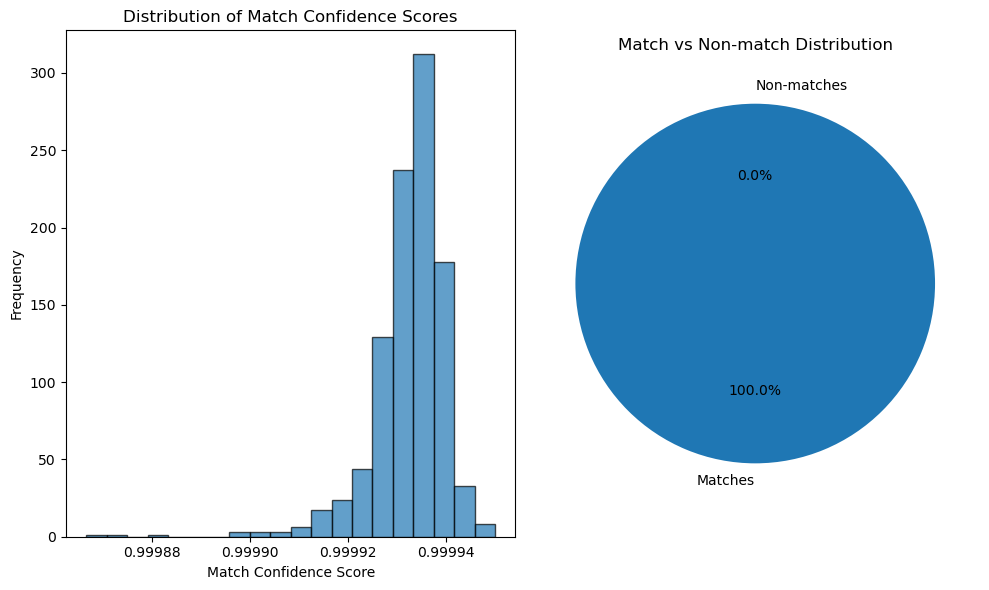


📋 Sample Results:

Result 1: ✅ MATCH (confidence: 1.000)
  Left:  COL primary_key VAL 678604863659 COL ifu VAL 2860014 COL raison_sociale VAL JAMA...
  Right: COL primary_key VAL 678604863659 COL ifu VAL 2860014 COL raison_sociale VAL JAMA...

Result 2: ✅ MATCH (confidence: 1.000)
  Left:  COL primary_key VAL 292057803428 COL ifu VAL 53960903 COL raison_sociale VAL BUI...
  Right: COL primary_key VAL 292057803428 COL ifu VAL 53960903 COL raison_sociale VAL BUI...

Result 3: ✅ MATCH (confidence: 1.000)
  Left:  COL primary_key VAL 996432433454 COL ifu VAL 52496734 COL raison_sociale VAL IS ...
  Right: COL primary_key VAL 996432433454 COL ifu VAL 52496734 COL raison_sociale VAL IS ...

Result 4: ✅ MATCH (confidence: 1.000)
  Left:  COL primary_key VAL 249108155489 COL ifu VAL 50328494 COL raison_sociale VAL JAW...
  Right: COL primary_key VAL 249108155489 COL ifu VAL 50328494 COL raison_sociale VAL JAW...

Result 5: ✅ MATCH (confidence: 1.000)
  Left:  COL primary_key VAL 687194804244 

In [31]:
# Analyze DITTO results
if os.path.exists(DATA_CONFIG['output_jsonl']):
    print("📊 Analyzing DITTO matching results...")
    
    stats = analyze_ditto_results(DATA_CONFIG['output_jsonl'])
    
    if 'error' not in stats:
        print("\n✅ Results Summary:")
        print(f"  Total pairs processed: {stats['total_pairs']}")
        print(f"  Matches found: {stats['matches']}")
        print(f"  Non-matches: {stats['non_matches']}")
        print(f"  Match rate: {stats['match_rate']:.2%}")
        print(f"  Average confidence: {stats['avg_score']:.3f}")
        
        # Plot score distribution
        if stats['score_distribution']:
            plt.figure(figsize=(10, 6))
            
            plt.subplot(1, 2, 1)
            plt.hist(stats['score_distribution'], bins=20, alpha=0.7, edgecolor='black')
            plt.xlabel('Match Confidence Score')
            plt.ylabel('Frequency')
            plt.title('Distribution of Match Confidence Scores')
            
            plt.subplot(1, 2, 2)
            match_counts = [stats['matches'], stats['non_matches']]
            labels = ['Matches', 'Non-matches']
            plt.pie(match_counts, labels=labels, autopct='%1.1f%%', startangle=90)
            plt.title('Match vs Non-match Distribution')
            
            plt.tight_layout()
            plt.show()
        
        # Show sample results
        print("\n📋 Sample Results:")
        with open(DATA_CONFIG['output_jsonl'], 'r') as f:
            for i, line in enumerate(f):
                if i >= 5:  # Show first 5 results
                    break
                result = json.loads(line)
                match_status = "✅ MATCH" if result.get('match', False) else "❌ NO MATCH"
                confidence = result.get('match_confidence', 0.0)
                print(f"\nResult {i+1}: {match_status} (confidence: {confidence:.3f})")
                print(f"  Left:  {result.get('left', '')[:80]}...")
                print(f"  Right: {result.get('right', '')[:80]}...")
    
    else:
        print(f"❌ Error analyzing results: {stats['error']}")
        
else:
    print("❌ No results file found to analyze")

## 10. Save Results to Hive

In [32]:
# Save results back to Hive
if os.path.exists(DATA_CONFIG['output_jsonl']):
    print(f"🔄 Saving results to Hive table: {DATA_CONFIG['output_table']}")
    
    try:
        # Read results
        results = []
        with open(DATA_CONFIG['output_jsonl'], 'r') as f:
            for line in f:
                if line.strip():
                    results.append(json.loads(line))
        
        print(f"📋 Loaded {len(results)} results")
        
        # Convert to DataFrame for easier handling
        results_df = pd.DataFrame([
            {
                'record_id': r.get('id', 0),
                'left_record': r.get('left', ''),
                'right_record': r.get('right', ''),
                'match_probability': r.get('match_confidence', 0.0),
                'is_match': r.get('match', False),
                'created_at': datetime.now().isoformat()
            }
            for r in results
        ])
        
        print("\n📊 Results DataFrame:")
        display(results_df.head())
        
        # Connect to Hive for saving
        if hive_conn.connection:
            cursor = hive_conn.connection.cursor()
            
            # Create table if doesn't exist
            create_table_sql = f"""
            CREATE TABLE IF NOT EXISTS {DATA_CONFIG['output_table']} (
                record_id INT,
                left_record STRING,
                right_record STRING,
                match_probability DOUBLE,
                is_match BOOLEAN,
                created_at STRING
            )
            STORED AS PARQUET
            """
            
            cursor.execute(create_table_sql)
            print(f"✅ Table {DATA_CONFIG['output_table']} created/verified")
            
            # Insert results (for large datasets, consider bulk loading)
            insert_count = 0
            for _, row in results_df.iterrows():
                # Escape single quotes in strings
                left_record = str(row['left_record']).replace("'", "''")[:1000]  # Truncate long records
                right_record = str(row['right_record']).replace("'", "''")[:1000]
                
                insert_sql = f"""
                INSERT INTO {DATA_CONFIG['output_table']} VALUES (
                    {row['record_id']},
                    '{left_record}',
                    '{right_record}',
                    {row['match_probability']},
                    {'true' if row['is_match'] else 'false'},
                    '{row['created_at']}'
                )
                """
                
                cursor.execute(insert_sql)
                insert_count += 1
                
                if insert_count % 10 == 0:
                    print(f"  Inserted {insert_count}/{len(results_df)} records...")
            
            print(f"✅ Successfully saved {insert_count} results to {DATA_CONFIG['output_table']}")
            
            # Verify insertion
            verify_df = hive_conn.execute_query(f"SELECT COUNT(*) as count FROM {DATA_CONFIG['output_table']}")
            print(f"🔍 Verification: {verify_df.iloc[0]['count']} records in table")
            
        else:
            print("❌ Not connected to Hive, cannot save results")
            print("💡 Results are available in the DataFrame above and the JSONL file")
            
    except Exception as e:
        print(f"❌ Error saving to Hive: {e}")
        print("💡 Results are still available in the JSONL file for manual processing")
        
else:
    print("❌ No results file found to save")

🔄 Saving results to Hive table: results.ditto_matches
📋 Loaded 1000 results

📊 Results DataFrame:


,record_id,left_record,right_record,match_probability,is_match,created_at
0,0,COL primary_key VAL 678604863659 COL ifu VAL 2...,COL primary_key VAL 678604863659 COL ifu VAL 2...,0.999943,1,2025-07-22T17:10:21.752447
1,0,COL primary_key VAL 292057803428 COL ifu VAL 5...,COL primary_key VAL 292057803428 COL ifu VAL 5...,0.999926,1,2025-07-22T17:10:21.752471
2,0,COL primary_key VAL 996432433454 COL ifu VAL 5...,COL primary_key VAL 996432433454 COL ifu VAL 5...,0.999933,1,2025-07-22T17:10:21.752475
3,0,COL primary_key VAL 249108155489 COL ifu VAL 5...,COL primary_key VAL 249108155489 COL ifu VAL 5...,0.999934,1,2025-07-22T17:10:21.752480
4,0,COL primary_key VAL 687194804244 COL ifu VAL 3...,COL primary_key VAL 687194804244 COL ifu VAL 3...,0.999906,1,2025-07-22T17:10:21.752483


2025-07-22 17:10:21,764 - INFO - 
            CREATE TABLE IF NOT EXISTS results.ditto_matches (
                record_id INT,
                left_record STRING,
                right_record STRING,
                match_probability DOUBLE,
                is_match BOOLEAN,
                created_at STRING
            )
            STORED AS PARQUET
            


❌ Error saving to Hive: TExecuteStatementResp(status=TStatus(statusCode=3, infoMessages=['*org.apache.hive.service.cli.HiveSQLException:Error while compiling statement: FAILED: SemanticException [Error 10072]: Database does not exist: results:17:16', 'org.apache.hive.service.cli.operation.Operation:toSQLException:Operation.java:335', 'org.apache.hive.service.cli.operation.SQLOperation:prepare:SQLOperation.java:199', 'org.apache.hive.service.cli.operation.SQLOperation:runInternal:SQLOperation.java:260', 'org.apache.hive.service.cli.operation.Operation:run:Operation.java:247', 'org.apache.hive.service.cli.session.HiveSessionImpl:executeStatementInternal:HiveSessionImpl.java:541', 'org.apache.hive.service.cli.session.HiveSessionImpl:executeStatement:HiveSessionImpl.java:516', 'org.apache.hive.service.cli.CLIService:executeStatement:CLIService.java:282', 'org.apache.hive.service.cli.thrift.ThriftCLIService:ExecuteStatement:ThriftCLIService.java:563', 'org.apache.hive.service.rpc.thrift.TCL

## 11. Cleanup and Summary

In [ ]:
# Cleanup and summary
print("🧹 Cleaning up and generating summary...")

# Close Hive connection
hive_conn.close()

# Generate workflow summary
summary = {
    'timestamp': datetime.now().isoformat(),
    'configuration': {
        'hive_table': DATA_CONFIG['input_table'],
        'output_table': DATA_CONFIG['output_table'],
        'ditto_model': DITTO_CONFIG['lm'],
        'sample_size': DATA_CONFIG['sample_size']
    },
    'files_created': [
        DATA_CONFIG['input_jsonl'],
        DATA_CONFIG['output_jsonl']
    ],
    'status': 'completed'
}

# Add results statistics if available
if os.path.exists(DATA_CONFIG['output_jsonl']):
    stats = analyze_ditto_results(DATA_CONFIG['output_jsonl'])
    if 'error' not in stats:
        summary['results'] = stats

# Save summary
summary_path = os.path.join(DATA_CONFIG['temp_dir'], 'workflow_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"📋 Summary saved to: {summary_path}")

print("\n🎉 Workflow Testing Complete!")
print("\n📋 Next Steps for Kubeflow Deployment:")
print("1. ✅ Test completed successfully - ready for Kubeflow packaging")
print("2. 🔧 Update configuration parameters in the Kubeflow pipeline")
print("3. 🐳 Build Docker image with all dependencies")
print("4. 🚀 Deploy pipeline to Kubeflow")

print(f"\n📁 Generated Files:")
for file_path in [DATA_CONFIG['input_jsonl'], DATA_CONFIG['output_jsonl'], summary_path]:
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        print(f"  ✅ {file_path} ({size} bytes)")
    else:
        print(f"  ❌ {file_path} (not created)")

## 12. Generate Kubeflow Pipeline Configuration

In [34]:
# Generate configuration for Kubeflow pipeline based on test results
print("🔧 Generating Kubeflow pipeline configuration...")

pipeline_config = {
    "pipeline_name": "hive-ditto-entity-matching",
    "description": "Entity matching pipeline with Hive integration",
    "parameters": {
        "hive_host": HIVE_CONFIG['host'],
        "hive_port": HIVE_CONFIG['port'],
        "hive_database": HIVE_CONFIG['database'],
        "hive_username": HIVE_CONFIG['username'],
        "input_table": DATA_CONFIG['input_table'],
        "output_table": DATA_CONFIG['output_table'],
        "ditto_task": DITTO_CONFIG['task'],
        "ditto_lm": DITTO_CONFIG['lm'],
        "ditto_max_len": DITTO_CONFIG['max_len'],
        "checkpoint_path": DITTO_CONFIG['checkpoint_path'],
        "use_gpu": DITTO_CONFIG['use_gpu'],
        "fp16": DITTO_CONFIG['fp16']
    },
    "resources": {
        "extract_step": {
            "cpu": "4",
            "memory": "16Gi"
        },
        "matching_step": {
            "cpu": "4",
            "memory": "16Gi",
            "gpu": "1" if DITTO_CONFIG['use_gpu'] else "0"
        },
        "save_step": {
            "cpu": "4",
            "memory": "16Gi"
        }
    },
    "volumes": {
        "data_volume": "50Gi",
        "models_volume": "10Gi"
    }
}

# Save pipeline configuration
config_path = os.path.join(DATA_CONFIG['temp_dir'], 'kubeflow_pipeline_config.json')
with open(config_path, 'w') as f:
    json.dump(pipeline_config, f, indent=2)

print(f"📋 Pipeline configuration saved to: {config_path}")

# Generate Docker build commands
docker_commands = f"""
# Docker Build Commands for Kubeflow Deployment

# 1. Build the DITTO image with Hive support
docker build -t your-registry/ditto-hive:latest -f Dockerfile .

# 2. Push to your container registry
docker push your-registry/ditto-hive:latest

# 3. Update the pipeline image references
# Edit hive_ditto_pipeline.py and update base_image='your-registry/ditto-hive:latest'

# 4. Compile the pipeline
python hive_ditto_pipeline.py

# 5. Upload the compiled pipeline YAML to Kubeflow
"""

docker_script_path = os.path.join(DATA_CONFIG['temp_dir'], 'docker_build_commands.txt')
with open(docker_script_path, 'w') as f:
    f.write(docker_commands)

print(f"🐳 Docker build commands saved to: {docker_script_path}")

print("\n✅ Kubeflow deployment preparation complete!")
print("\n📋 Configuration Summary:")
print(json.dumps(pipeline_config, indent=2))

🔧 Generating Kubeflow pipeline configuration...
📋 Pipeline configuration saved to: ./temp_notebook/kubeflow_pipeline_config.json
🐳 Docker build commands saved to: ./temp_notebook/docker_build_commands.txt

✅ Kubeflow deployment preparation complete!

📋 Configuration Summary:
{
  "pipeline_name": "hive-ditto-entity-matching",
  "description": "Entity matching pipeline with Hive integration",
  "parameters": {
    "hive_host": "172.17.235.21",
    "hive_port": 10000,
    "hive_database": "preprocessed_analytics",
    "hive_username": "lhimer",
    "input_table": "preprocessed_analytics.model_reference",
    "output_table": "results.ditto_matches",
    "ditto_task": "person_records",
    "ditto_lm": "bert",
    "ditto_max_len": 64,
    "checkpoint_path": "checkpoints/",
    "use_gpu": true,
    "fp16": true
  },
  "resources": {
    "extract_step": {
      "cpu": "4",
      "memory": "16Gi"
    },
    "matching_step": {
      "cpu": "4",
      "memory": "16Gi",
      "gpu": "1"
    },
   